In [1]:
from langchain_tavily import TavilySearch
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage, AIMessage
from typing import Annotated

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


from langgraph.types import Command, interrupt
from dotenv import load_dotenv
import os

load_dotenv()

GROQ_MODEL = os.getenv("GROQ_MODEL")
GROQ_API = os.getenv("GROQ_API_KEY")
llm = ChatGroq(api_key=GROQ_API, model=GROQ_MODEL)


In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


In [3]:
@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


In [4]:
tool = TavilySearch(max_results=1)
tools = [tool, human_assistance]

llm_with_tools = llm.bind_tools(tools)


In [5]:
def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])

    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


In [6]:
graph_builder = StateGraph(State)


In [7]:
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")


In [8]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)


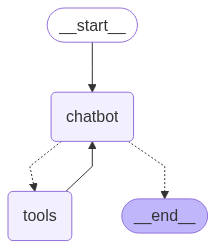

In [81]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [9]:
user_input = "I need some expert guidance for making a tasty cake without using eggs. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================ Human Message =================================

I need some expert guidance for making a tasty cake without using eggs. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_sv85)
 Call ID: call_sv85
  Args:
    exclude_domains: ['twitter.com']
    include_images: True
    query: egg-free cake recipe
    search_depth: advanced
    time_range: day
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "egg-free cake recipe", "follow_up_questions": null, "answer": null, "images": ["https://www.gretchensveganbakery.com/wp-content/uploads/2023/01/4-egg-free-recipes-resized-.jpg", "https://bakewithshivesh.com/wp-content/uploads/2018/03/IMG-7847-1-1320x1650.jpg", "https://www.vegrecipesofindia.com/wp-content/uploads/2021/03/eggless-vanilla-cake-1-1024x1536.jpg", "https://www.allrecipes.c

In [10]:
human_response = (
    "We, the experts, are here to help! We'd recommend you try using yogurt or mashed bananas as egg substitutes."
    " They're reliable and help make your cake moist and delicious without using eggs."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_1z5e)
 Call ID: call_1z5e
  Args:
    query: I need a simple egg-free cake recipe, can you summarize the best one for me?
================================= Tool Message =================================
Name: human_assistance

We, the experts, are here to help! We'd recommend you try using yogurt or mashed bananas as egg substitutes. They're reliable and help make your cake moist and delicious without using eggs.
================================== Ai Message ==================================

Here's a simple egg-free cake recipe using yogurt:

<tool-use>{"tool_calls":[]}</tool-use>

Here's a recipe for a delicious egg-free cake:

Ingredients:

* 1 1/2 cups all-purpose flour
* 1 cup granulated sugar
* 1 tsp baking powder
* 1/2 tsp baking soda
* 1/4 tsp salt
* 1/2 cup plain yogurt
* 1/2 cup vegetable oil
* 1 tsp vanilla extract
* 1 cup mixed berries (optional)

Instructi

In [11]:
def handle_user_input():
    """Helper function to get user input with conversation history"""
    while True:
        user_input = input("You (type 'exit' to end): ")
        if user_input.lower() == 'exit':
            return None
        return user_input


# Initialize conversation
config = {"configurable": {"thread_id": "1"}}
messages = []

while True:
    # Get user input
    user_input = handle_user_input()
    if user_input is None:
        break

    # Add to message history
    messages.append({"role": "user", "content": user_input})

    # Stream the conversation
    events = graph.stream(
        {"messages": messages},
        config,
        stream_mode="values"
    )

    # Process and display responses
    for event in events:
        if "messages" in event:
            last_message = event["messages"][-1]
            last_message.pretty_print()
            messages.append(last_message)


================================ Human Message =================================

what else can I add to make it more tasty?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_g36s)
 Call ID: call_g36s
  Args:
    exclude_domains: ['twitter.com']
    include_images: True
    query: egg-free cake add-ins
    search_depth: advanced
    time_range: day
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "egg-free cake add-ins", "follow_up_questions": null, "answer": null, "images": ["https://i.pinimg.com/originals/85/8c/13/858c1366a16e76229e6257d0450a2460.png", "https://cakebycourtney.com/wp-content/uploads/2018/03/IMG_4293.jpg", "https://cdn.mos.cms.futurecdn.net/VitUumZjbX6Cr6k86TYCiA-1200-80.jpg", "https://cakebycourtney.com/wp-content/uploads/2018/03/IMG_4294.jpg", "https://www.gretchensveganbakery.com/wp-content/uploads/2023/01/4-egg-free-reci